In [1]:
using PorousMaterials
using PyPlot
using DataFrames
using CSV
using Interpolations
using Optim
using Printf

┌ Info: Precompiling PorousMaterials [68953c7c-a3c7-538e-83d3-73516288599e]
└ @ Base loading.jl:1260
┌ Warning: Package PorousMaterials does not have Test in its dependencies:
│ - If you have PorousMaterials checked out for development and have
│   added Test as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with PorousMaterials
└ Loading Test into PorousMaterials from project dependency, future warnings for PorousMaterials are suppressed.


[1] Tam,  W.;  Jackson,  A.;  Nishida,  E.;  Ka-sai, Y.; Tsujihata, A.; Kajiwara, K. Designand  manufacture  of  the  ETS  VIII  xenontank.36thAIAA/ASME/SAE/ASEEJoint  Propulsion  Conference  and  Exhibit.2000; p 3677.(https://doi.org/10.2514/6.2000-3677)

[2] Welsch,  G.;  Boyer,  R.;  Collings,  E.Materials properties handbook: titanium alloys;ASM international, 1993. 

[3] Niinomi,   M.   Mechanical   properties   of biomedical  titanium  alloys. Materials Science and Engineering: A1998,243, 231–236.

[4] propellant storage considerations [link](https://erps.spacegrant.org/uploads/images/images/iepc_articledownload_1988-2007/1991index/IEPC1991-107.pdf)

define variables

Tank material anealed Ti-6Al-4V characteristics [1], [2], [3]

In [2]:
const ρ_t = 4428.785 # kg/m³ (convdrted from 0.16 lb/in³ listed in [2])
const σ_y = 8250.0 # bar Yield Strength (lower-limit of reported values [3])
const temperature = 298.0 # K
const β = 0.5 # safety factor

0.5

Common amount of xenon gas required to bring into space [1].

In [3]:
xe_atomic_mass = read_atomic_masses()[:Xe] # in g / mol

mass_desired_xe_propellant = 89.0 # kg Xe
mol_desired_xe_propellant = mass_desired_xe_propellant * 1000 / xe_atomic_mass # mol Xe

677.8731539381383

read in density of xenon data (in bulk and adsorbed conditions)

In [4]:
df_xtal = CSV.read("df_crystal.csv")

const mof_to_K = Dict(row.:xtal => row.:K_inv_bar for row in eachrow(df_xtal))
const mof_to_M = Dict(row.:xtal => row.:M_mol_m3 for row in eachrow(df_xtal))
const mof_to_ρ = Dict(row.:xtal => row.:ρ_kg_m3 for row in eachrow(df_xtal))

Dict{String,Float64} with 10 entries:
  "Ni-MOF-74"        => 1194.12
  "SBMOF-2"          => 1191.92
  "FMOF-Cu"          => 1619.15
  "CC3"              => 958.585
  "Activated-Carbon" => 500.0
  "COF-103"          => 388.73
  "SBMOF-1"          => 1570.4
  "HKUST-1"          => 879.096
  "MOF-505"          => 926.618
  "Co-formate"       => 1821.5

In [5]:
df_xtal = CSV.read("df_crystal.csv")

,xtal,M_mol_m3,K_inv_bar,ρ_kg_m3
,String,Float64,Float64,Float64
1,SBMOF-1,2217.01,37.2343,1570.4
2,CC3,2630.2,7.57403,958.585
3,Ni-MOF-74,8546.38,1.51701,1194.12
4,HKUST-1,2622.07,2.04084,879.096
5,SBMOF-2,4426.9,3.2665,1191.92
6,Co-formate,4197.35,6.49703,1821.5
7,FMOF-Cu,2816.78,0.345207,1619.15
8,MOF-505,11464.2,0.975039,926.618
9,Activated-Carbon,2627.48,2.26493,500.0


In [6]:
crystal_names = ["SBMOF-1", "CC3", "Ni-MOF-74", "HKUST-1", "SBMOF-2", "Co-formate",
    "FMOF-Cu", "MOF-505", "Activated-Carbon", "COF-103"] 

mof_to_marker = Dict("SBMOF-1" => "o", "CC3" => ">", "Ni-MOF-74" => "<", "HKUST-1" => "*", "SBMOF-2" => "H", 
    "Co-formate" => "^", "FMOF-Cu" => "s", "MOF-505" => "v",
    "Activated-Carbon" => "d", "COF-103" => "8")
mof_to_color = Dict(zip(crystal_names, ["C$i" for i = 1:length(crystal_names)]))

Dict{String,String} with 10 entries:
  "Ni-MOF-74"        => "C3"
  "SBMOF-2"          => "C5"
  "FMOF-Cu"          => "C7"
  "CC3"              => "C2"
  "Activated-Carbon" => "C9"
  "COF-103"          => "C10"
  "SBMOF-1"          => "C1"
  "HKUST-1"          => "C4"
  "MOF-505"          => "C8"
  "Co-formate"       => "C6"

## xenon gas properties

Source for experimental data for (real) xenon gas: NIST. Load in NIST data on xenon at 298 K. source for critical pressure here. We linearly interpolate pressures for xenon gas densities.

In [7]:
df_xe = vcat(CSV.read(joinpath("data", "NIST_data", "low_pressure_xenon_NIST_data.txt"))[2:end, 2:3],
             CSV.read(joinpath("data", "NIST_data", "xenon_NIST_data.txt"))[:, 2:3])
df_xe[:, Symbol("Density (mol/m³)")] = df_xe[:, Symbol("Density (mol/l)")] * 1000 # convert L to m³
sort!(df_xe, Symbol("Pressure (bar)"))

,Pressure (bar),Density (mol/l),Density (mol/m³)
,Float64,Float64,Float64
1,0.0,0.0,0.0
2,0.0025,0.0001009,0.1009
3,0.005,0.0002018,0.2018
4,0.0075,0.00030271,0.30271
5,0.01,0.00040362,0.40362
6,0.0125,0.00050453,0.50453
7,0.015,0.00060544,0.60544
8,0.0175,0.00070636,0.70636
9,0.02,0.00080728,0.80728


viewing density of ideal gas at our array of pressures for comparison

In [8]:
# Universal Gas Constant:
const R = 8.3144598e-5; # m³-bar/(K-mol)
P_range = range(0.0, 200.0, length=200)
# ideal gas density
ρ_ideal_gas = P_range / (R * temperature); # mol / m³

In [9]:
ρ_xe = LinearInterpolation(df_xe[:, Symbol("Pressure (bar)")], df_xe[:, Symbol("Density (mol/m³)")]) # applying (interested pressure) gives interpolated density

1203-element extrapolate(interpolate((::Array{Float64,1},), ::Array{Float64,1}, Gridded(Linear())), Throw()) with element type Float64:
     0.0
     0.1009
     0.2018
     0.30271
     0.40362
     0.50453
     0.60544
     0.70636
     0.80728
     0.9082
     1.0090999999999999
     1.1100999999999999
     1.211
     ⋮
 17659.0
 17664.0
 17669.0
 17673.0
 17678.0
 17683.0
 17688.0
 17693.0
 17698.0
 17702.0
 17707.0
 17712.0

In [10]:
ρ_xe(4.0) # Testing interpolations 

164.93834390536603

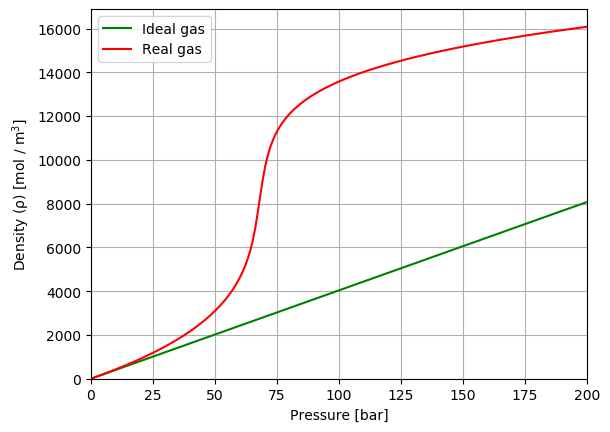

In [11]:
figure()
plot(P_range, ρ_ideal_gas, color="green", label="Ideal gas")
plot(P_range, ρ_xe(P_range), color="red", label="Real gas")
xlabel("Pressure [bar]")
ylabel("Density (ρ) [mol / m\$^3\$]")
ylim(ymin=0.0)
xlim(xmin=0.0, xmax=200)
legend()
grid()

In [12]:
function ρ_xe_ads(P::Float64, xtal::String)
    M = mof_to_M[xtal]
    K = mof_to_K[xtal]
    return (M * K * P) / (1 + K * P)
end

ρ_xe_ads (generic function with 1 method)

In [13]:
Pδ = [0.00001, 100] # initial pressure range guess

2-element Array{Float64,1}:
   1.0e-5
 100.0

In [14]:
# radius of vessel needed
function r(P::Float64, xtal::String) # ads Xe storage
    return (3.0 * mol_desired_xe_propellant / (4.0 * π * ρ_xe_ads(P, xtal))) ^ (1/3)
end

function t(P::Float64, xtal::String) # ads Xe storage
    return P * r(P, xtal) / (2.0 * β * σ_y)
end

# mass of tank material needed
function mₜ(P::Float64, xtal::String) # ads Xe storage
    return 4.0 * π * (r(P, xtal) ^ 2.0) * t(P, xtal) * ρ_t
end

# mass of adsorbent needed
function mₐ(P::Float64, xtal::String) # ads Xe storage (of course)
    return mof_to_ρ[xtal] * mol_desired_xe_propellant / ρ_xe_ads(P, xtal)
end

function optimum_storage(xtal::String) # ads Xe storage
    # use Optim.jl to find the minimum
    res = optimize(P -> (mₜ(P, xtal) + mₐ(P, xtal)), Pδ[1], Pδ[2])
    @assert res.converged "Optimization not successful."
    return res
end



function r(P::Float64) # bulk Xe storage
    return (3.0 * mol_desired_xe_propellant / (4.0 * π * ρ_xe(P))) ^ (1/3)
end

function t(P::Float64) # bulk Xe storage
    return P * r(P) / (2.0 * β * σ_y)
end

function mₜ(P::Float64)  # bulk Xe storage
    return 4.0 * π * (r(P) ^ 2.0) * t(P) * ρ_t
end

function optimum_storage() # bulk Xe storage
    return optimize(P -> mₜ(P[1]), Pδ[1], Pδ[2])
end

optimum_storage (generic function with 2 methods)

In [15]:
optimum_storage("SBMOF-1").minimizer

5.117497962440876

### Bulk Xe Storage

In [16]:
bulk_res = optimum_storage()
P_range = range(0.0, 200.0, length=200)

0.0:1.0050251256281406:200.0

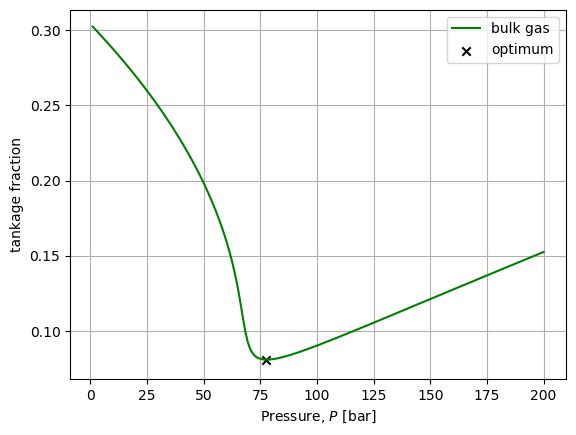

In [17]:
figure()
plot(P_range, mₜ.(P_range) / mass_desired_xe_propellant, color="green", label="bulk gas")
xlabel(L"Pressure, $P$ [bar]")
ylabel("tankage fraction")
scatter([bulk_res.minimizer], [bulk_res.minimum] / mass_desired_xe_propellant, marker="x", color="black", label="optimum")
#ylim(ymin=0.0)
#xlim(xmin=0.0, xmax=200)
legend()
grid()

### Adsorbed Xe Storage

In [18]:
P_range = range(1.0, 50.0, length=200)

1.0:0.24623115577889448:50.0

In [19]:
mof_to_optimum_results = Dict()

for mof in crystal_names
    opt = optimum_storage(mof)
    mof_to_optimum_results[mof] = Dict()
    mof_to_optimum_results[mof]["storage pressure [bar]"] = opt.minimizer
    mof_to_optimum_results[mof]["tankage fraction"] = opt.minimum / mass_desired_xe_propellant
    mof_to_optimum_results[mof]["thickness [m]"] = t(opt.minimizer, mof)
    mof_to_optimum_results[mof]["radius [m]"] = r(opt.minimizer, mof)
    mof_to_optimum_results[mof]["mass of tank material [kg]"] = mₜ(opt.minimizer, mof)
    mof_to_optimum_results[mof]["mass of mof [kg]"] = mₐ(opt.minimizer, mof)
    mof_to_optimum_results[mof]["total mass of tank [kg]"] = mₐ(opt.minimizer, mof) + mₜ(opt.minimizer, mof)
end

mof_to_optimum_results["CC3"]["tankage fraction"]

2.8591817304197127

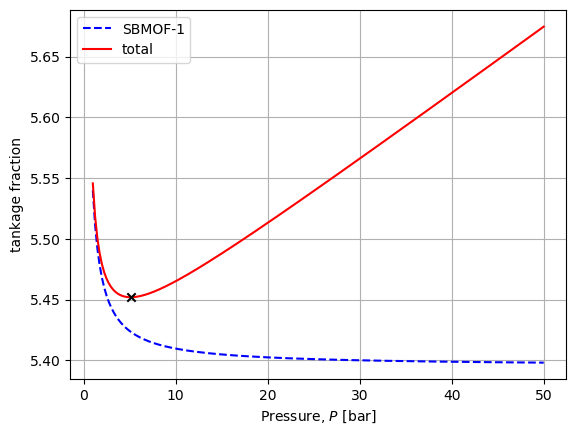

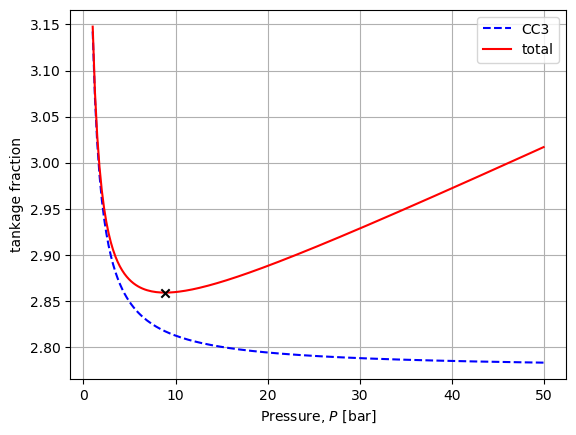

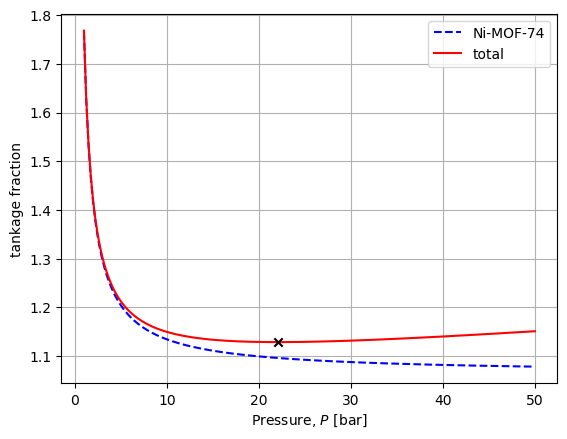

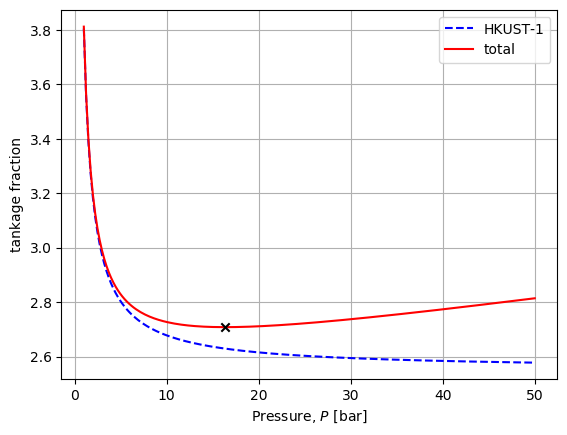

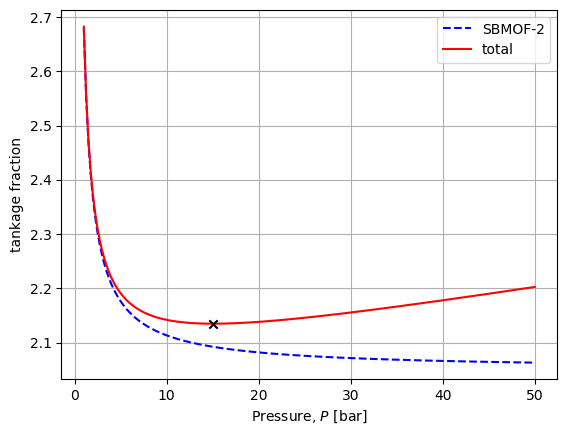

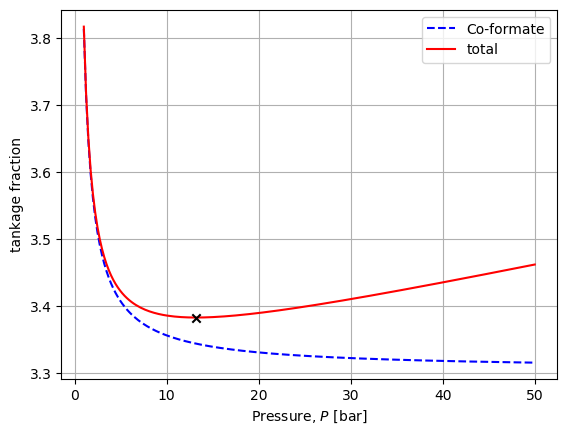

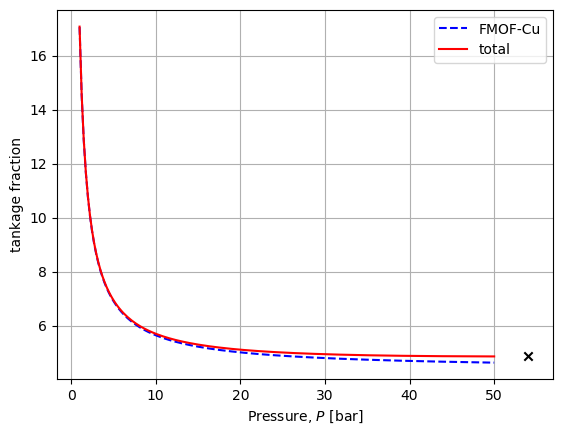

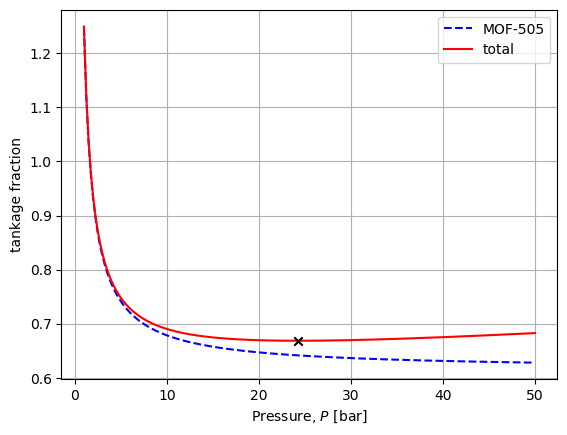

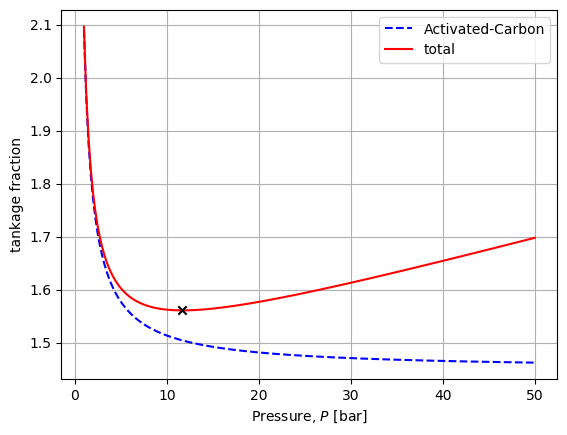

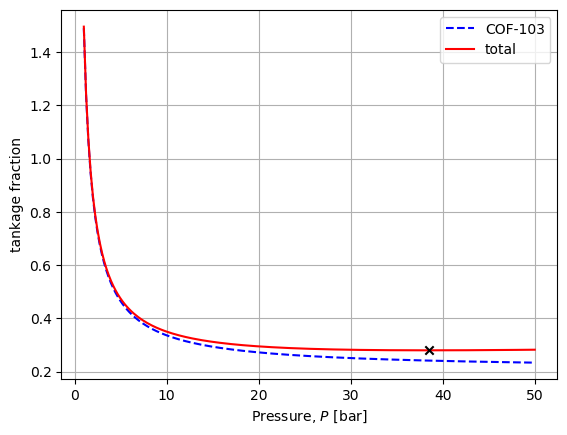

In [20]:
# adsorbent and total
for mof in crystal_names    
    figure()
#    plot(P_range, mₜ.(P_range, "SBMOF-1"), color="green", linestyle="--", label="tank material")
    plot(P_range, mₐ.(P_range, mof) / mass_desired_xe_propellant, color="blue", linestyle="--", label=mof)
    plot(P_range, (mₜ.(P_range, mof) + mₐ.(P_range, mof)) / mass_desired_xe_propellant, color="red", label="total")
    xlabel(L"Pressure, $P$ [bar]")
    ylabel("tankage fraction")
#    ylim(ymax=500)
#    xlim(xmin=0.0, xmax=10)
    scatter(mof_to_optimum_results[mof]["storage pressure [bar]"], mof_to_optimum_results[mof]["tankage fraction"],
            marker="x", color="black", zorder=1000)
    legend()
    grid()
end

In [21]:
function make_plots(mof::String)
    println("optimum: ")
    println("\tstorage pressure [bar] = ", mof_to_optimum_results[mof]["storage pressure [bar]"])
    println("\tmass of tank material [kg] = ", mof_to_optimum_results[mof]["mass of tank material [kg]"])
    println("\ttankage fraction [kg] = ", mof_to_optimum_results[mof]["tankage fraction"])

    fig, axs = subplots(3, 1, figsize=(8, 12), 
                    sharex=true, sharey=false, tight_layout=true)

    # tank radius
    axs[1].plot(P_range, r.(P_range, mof), color="C2")
    axs[1].set_ylabel("radius [m]")

    # tank thickness
    axs[2].plot(P_range, t.(P_range, mof), color="C3")
    axs[2].set_ylabel("thickness [m]")
    # axs[3].axvline(x=xe_critical_pressure, linestyle="--", color="k", label="crit. pressure", lw=1)

    
    # mass of tank
    axs[3].plot(P_range, mₜ.(P_range, mof), color="C7", linestyle="--", label="tank walls")
    axs[3].plot(P_range, mₐ.(P_range, mof), color="C5", linestyle="-.", label="adsorbent")
    axs[3].plot(P_range, (mₜ.(P_range, mof) + mₐ.(P_range, mof)), color="C6", label="total")
    axs[3].set_ylabel("mass [kg]")
    axs[3].plot([mof_to_optimum_results[mof]["storage pressure [bar]"], mof_to_optimum_results[mof]["storage pressure [bar]"]],
                [0, mof_to_optimum_results[mof]["total mass of tank [kg]"]], color="gray", linestyle="--", label="optimum"
                )
    axs[3].legend()
    axs[3].set_ylim(ymin=0.0)
    
    #(bbox_to_anchor=(0., 1.02, 1., .102), loc="lower left", ncol=2, mode="expand", borderaxespad=0)

    xlabel(L"pressure, $P$ [bar]")
    xlim([minimum(P_range), maximum(P_range)])
    
    # plot tankage fraction
#    figure()
#    scatter(P_range[argmin_tankage_fraction], mof_to_optimum_results[mof]["tankage fraction"][argmin_tankage_fraction],
#        label="minimum", color="b", zorder=999)
#    plot(P_range, mof_to_optimum_results[mof]["tankage fraction"], color="C4")
#    xlabel("storage pressure [bar]")
#    ylabel("total mass of tank / mass Xe")
#    legend()
#    title("tankage fraction of adsorbed Xe")
#    # ylim(ymin=0.0)
#    print("Total tank mass at optimum pressure = ", mof_to_optimum_results[mof]["tankage fraction"][argmin_tankage_fraction])

end

make_plots (generic function with 1 method)

optimum: 
	storage pressure [bar] = 

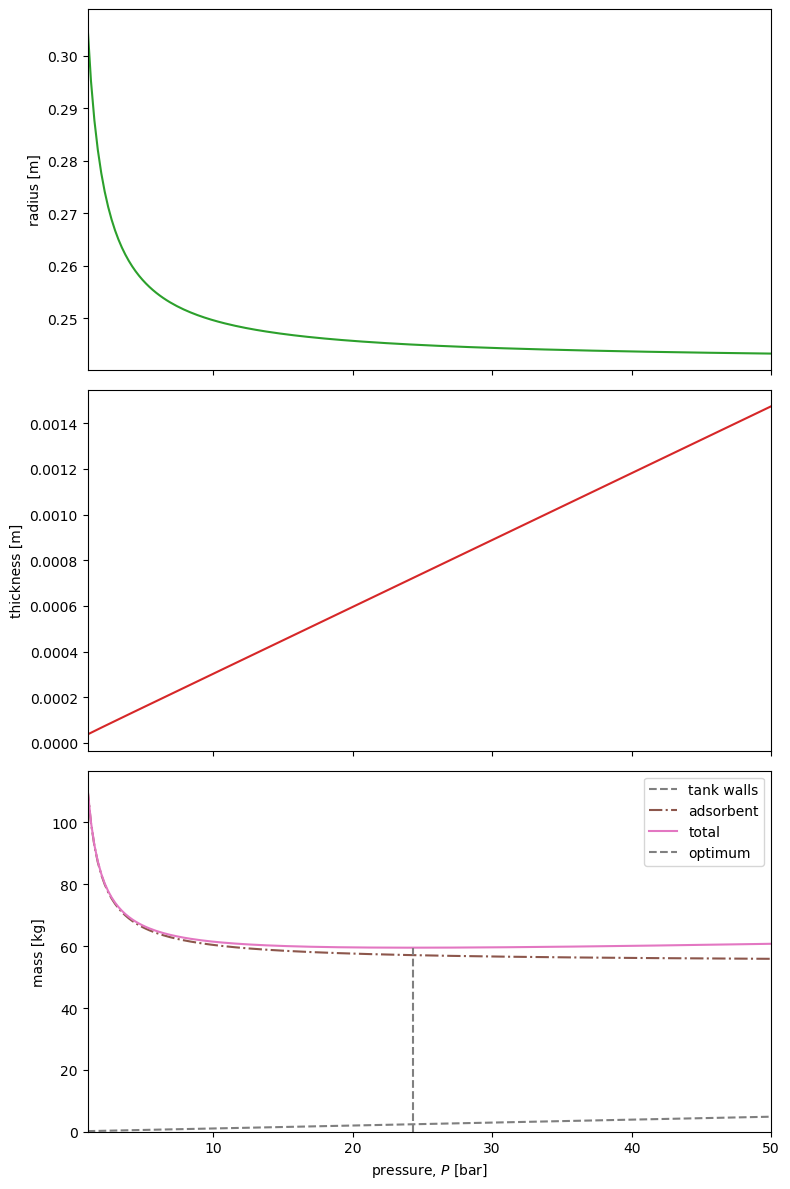

24.292012056804094
	mass of tank material [kg] = 2.410904983398179
	tankage fraction [kg] = 0.668705344690688


(1.0, 50.0)

In [22]:
make_plots("MOF-505")

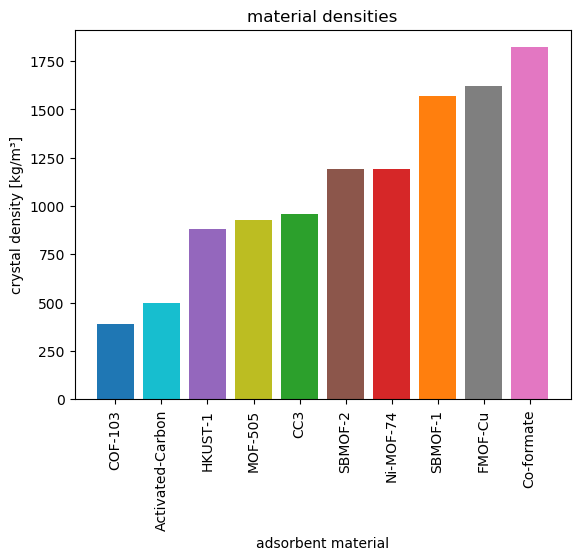

Dict{String,Float64} with 10 entries:
  "Ni-MOF-74"        => 1194.12
  "SBMOF-2"          => 1191.92
  "FMOF-Cu"          => 1619.15
  "CC3"              => 958.585
  "Activated-Carbon" => 500.0
  "COF-103"          => 388.73
  "SBMOF-1"          => 1570.4
  "HKUST-1"          => 879.096
  "MOF-505"          => 926.618
  "Co-formate"       => 1821.5

In [23]:
# Put into MOF_Space_Plot, use the dataframe in the notebook

# ρ_crystal = Dict{String, Float64}()

# # find crystal density using PorousMaterials.jl
# for crystal_name in crystal_names
#     if crystal_name != "Activated-Carbon"
#         if crystal_name == "COF-103"
#             framework = Framework(crystal_name * ".cif")
#             strip_numbers_from_atom_labels!(framework)
#             ρ_crystal[crystal_name] = crystal_density(framework) # kg/m³
#         else    
#             framework = Framework(crystal_name * ".cssr")
#             strip_numbers_from_atom_labels!(framework)
#             ρ_crystal[crystal_name] = crystal_density(framework) # kg/m³
#         end
#     else
#         ρ_crystal[crystal_name] = 500.0 # kg/m³
#     end
# end

# df_ρ_crystal = DataFrame(xtal=collect(keys(ρ_crystal)), rho=collect(values(ρ_crystal)))
# df_ρ_crystal[!, :color] = map(m -> mof_to_color[m], df_ρ_crystal[:, :xtal])


sort!(df_ρ_crystal, :rho)

figure()
xlabel("adsorbent material")
ylabel("crystal density [kg/m³]")
bar(1:nrow(df_ρ_crystal), df_ρ_crystal[:, :rho], color=df_ρ_crystal[:, :color])
xticks(1:nrow(df_ρ_crystal), df_ρ_crystal[:, :xtal], rotation="vertical")
title("material densities")

ρ_crystal # kg/m³

### visualizing the scatter of MOFs in MOF space

MOF space defined by Langmuir model parameters

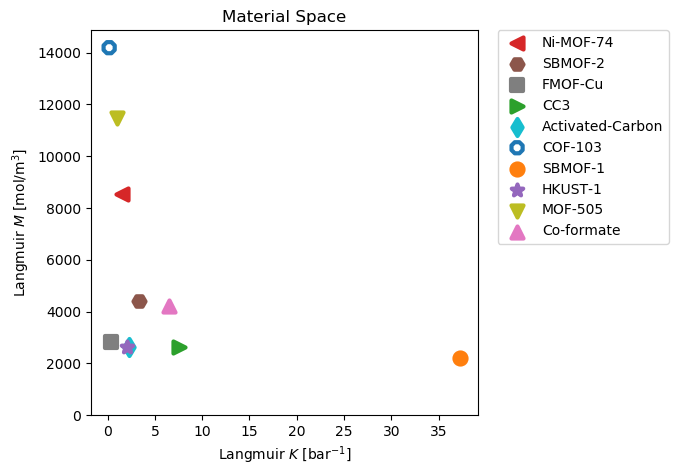

PyObject <matplotlib.legend.Legend object at 0x000000003968CAC8>

In [24]:
# put into MOF_Space_Plot

figure(figsize=(5,5))
title("Material Space")
for xtal in keys(mof_to_optimum_results)
    scatter(mof_to_K[xtal], mof_to_M[xtal], 
        label=xtal, marker=mof_to_marker[xtal], s=75, clip_on=false, 
        color=xtal == "COF-103" ? "none" : mof_to_color[xtal], 
        edgecolor=mof_to_color[xtal], lw=3)
end
xlabel(L"Langmuir $K$ [bar$^{-1}$]")
ylabel(L"Langmuir $M$ [mol/m$^3$]")
ylim(ymin=0.0)
# xlim(xmin=0.0)
legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)

### visualizing the reduction in storage volume given by the MOFs

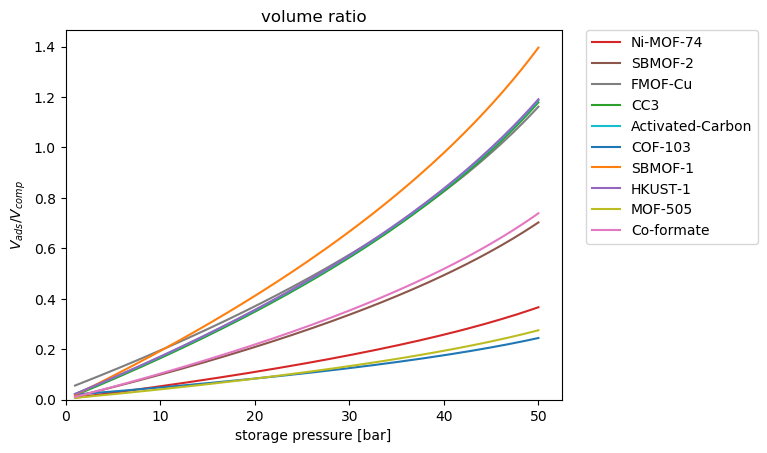

PyObject Text(0.5, 1, 'volume ratio')

In [25]:
figure()
for xtal in keys(mof_to_optimum_results)
    plot(P_range, 
        r.(P_range, xtal) .^ 3 ./      # ads
        r.(P_range) .^ 3,              # bulk
        label=xtal, color=mof_to_color[xtal])
end
xlabel("storage pressure [bar]")
ylabel(L"$V_{ads} / V_{comp}$")
legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)
ylim(ymin=0.0)
xlim(xmin=0.0)
title("volume ratio")       

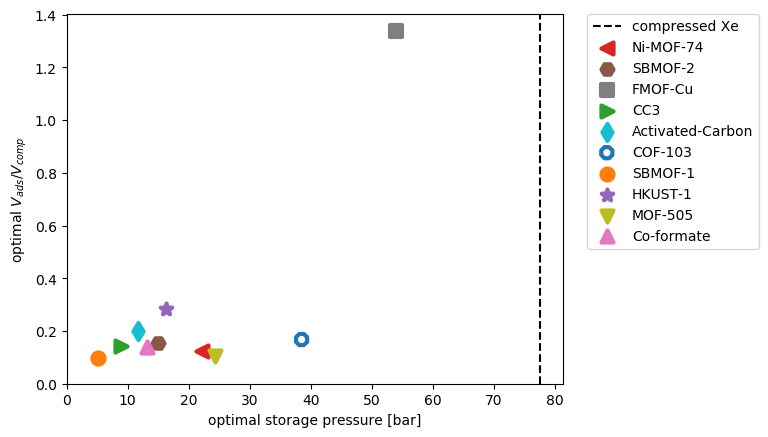

PyObject <matplotlib.legend.Legend object at 0x0000000039259B88>

In [26]:
#Check with cory -- should we use mol_desired / density langmuir instead?

figure()
xlabel("optimal storage pressure [bar]")
ylabel(L"optimal $V_{ads} / V_{comp}$")
for mof in keys(mof_to_optimum_results)
    # find ratio of volumes at this optimal storage pressure
    scatter(mof_to_optimum_results[mof]["storage pressure [bar]"],
            r(mof_to_optimum_results[mof]["storage pressure [bar]"], mof) ^ 3 ./      # ads
            r(mof_to_optimum_results[mof]["storage pressure [bar]"]) ^ 3,              # bulk, 
        label=mof, marker=mof_to_marker[mof], s=75, clip_on=false,
        color=mof == "COF-103" ? "none" : mof_to_color[mof], 
        edgecolor=mof_to_color[mof], lw=3)
end

axvline(x=[bulk_res.minimizer], linestyle="--", color="black", label="compressed Xe")
ylim(ymin=0.0)
xlim(xmin=0.0)
legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)

### optimal storage pressure vs. tankage fraction

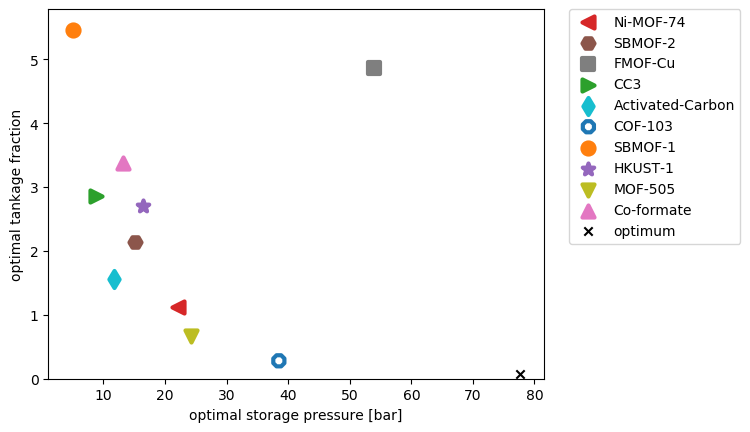

PyObject <matplotlib.legend.Legend object at 0x00000000391A7EC8>

In [27]:
figure()
xlabel("optimal storage pressure [bar]")
ylabel("optimal tankage fraction")
for mof in keys(mof_to_optimum_results)
    scatter(mof_to_optimum_results[mof]["storage pressure [bar]"],
            mof_to_optimum_results[mof]["tankage fraction"],
        label=mof, marker=mof_to_marker[mof], s=75, clip_on=false, 
        color=mof == "COF-103" ? "none" : mof_to_color[mof], 
        edgecolor=mof_to_color[mof], lw=3)
end

scatter([bulk_res.minimizer], [bulk_res.minimum] / mass_desired_xe_propellant, 
        marker="x", color="black", label="optimum")

ylim(ymin=0.0)
# xlim(xmin=0.0)
legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)

### crystal density of adsorbent material affects tankage fraction

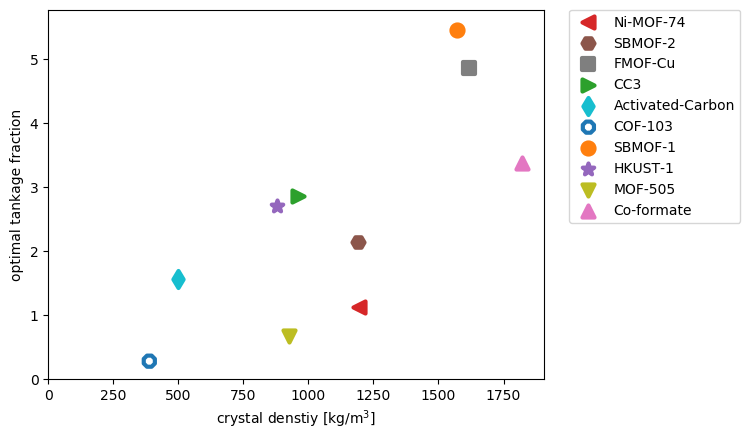

PyObject <matplotlib.legend.Legend object at 0x00000000390F52C8>

In [28]:
figure()
xlabel(L"crystal denstiy [kg/m$^3$]")
ylabel("optimal tankage fraction")
for mof in keys(mof_to_optimum_results)
    scatter(ρ_crystal[mof], mof_to_optimum_results[mof]["tankage fraction"],
    label=mof, marker=mof_to_marker[mof], s=75, clip_on=false,
    color=mof == "COF-103" ? "none" : mof_to_color[mof],
    edgecolor=mof_to_color[mof], lw=3)
end
ylim(ymin=0.0)
xlim(xmin=0.0)
legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)

### mass of tank needed, partitioned by adsorbant material vs. tank material

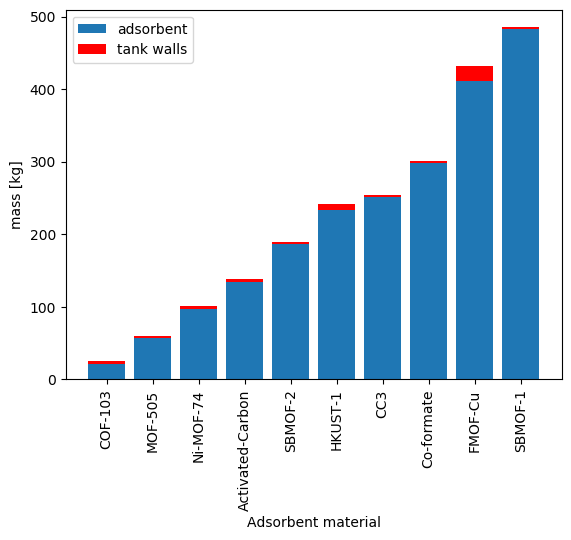

(PyCall.PyObject[PyObject <matplotlib.axis.XTick object at 0x00000000468D9808>, PyObject <matplotlib.axis.XTick object at 0x00000000468C3848>, PyObject <matplotlib.axis.XTick object at 0x0000000042A038C8>, PyObject <matplotlib.axis.XTick object at 0x0000000043060B48>, PyObject <matplotlib.axis.XTick object at 0x0000000039757E48>, PyObject <matplotlib.axis.XTick object at 0x00000000438EC248>, PyObject <matplotlib.axis.XTick object at 0x00000000438EC788>, PyObject <matplotlib.axis.XTick object at 0x00000000438EF248>, PyObject <matplotlib.axis.XTick object at 0x00000000468F6FC8>, PyObject <matplotlib.axis.XTick object at 0x00000000438EF948>], PyCall.PyObject[PyObject Text(1, 0, 'COF-103'), PyObject Text(2, 0, 'MOF-505'), PyObject Text(3, 0, 'Ni-MOF-74'), PyObject Text(4, 0, 'Activated-Carbon'), PyObject Text(5, 0, 'SBMOF-2'), PyObject Text(6, 0, 'HKUST-1'), PyObject Text(7, 0, 'CC3'), PyObject Text(8, 0, 'Co-formate'), PyObject Text(9, 0, 'FMOF-Cu'), PyObject Text(10, 0, 'SBMOF-1')])

In [36]:
ids = 1:length(mof_to_optimum_results)
ids_sorted = sortperm([mof_to_optimum_results[mof]["tankage fraction"] for mof in keys(mof_to_optimum_results)])                      

figure()
xlabel("Adsorbent material")
ylabel("mass [kg]")
m_mof = [mof_to_optimum_results[mof]["mass of mof [kg]"] for mof in keys(mof_to_optimum_results)]
m_tank_walls = [mof_to_optimum_results[mof]["mass of tank material [kg]"] for mof in keys(mof_to_optimum_results)]
bar(ids, m_mof[ids_sorted], label="adsorbent")
bar(ids, m_tank_walls[ids_sorted], bottom=m_mof[ids_sorted],label="tank walls", color="red")

legend()
xticks(ids, collect(keys(mof_to_optimum_results))[ids_sorted], rotation="vertical")